In [15]:
import pandahouse 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

connection = {
'host': 'https://clickhouse.lab.karpov.courses',
'password': 'dpo_python_2020',
'user': 'student',
'database': 'simulator_20220220'
}

sns.set(rc = {'figure.figsize':(15,10)})

In [2]:
# Task 1
q = '''
      Select 
          exp_group,
          user_id,
          countIf(user_id, action = 'like') as likes,
          countIf(user_id, action = 'view') as views,
          likes/views as CTR
      from simulator_20220220.feed_actions
      where toDate(time) >= '2022-02-06' and toDate(time) <= '2022-02-12' 
          and exp_group in (2,3)
      group by exp_group, user_id
     '''

df_AA = pandahouse.read_clickhouse(q, connection = connection)

In [3]:
p_values = []
for _ in range(10000):
  p_values.append(stats.ttest_ind(df_AA[df_AA.exp_group == 2].CTR.sample(500, replace = True), 
                  df_AA[df_AA.exp_group == 3].CTR.sample(500, replace = True),
                  equal_var = False)[1])

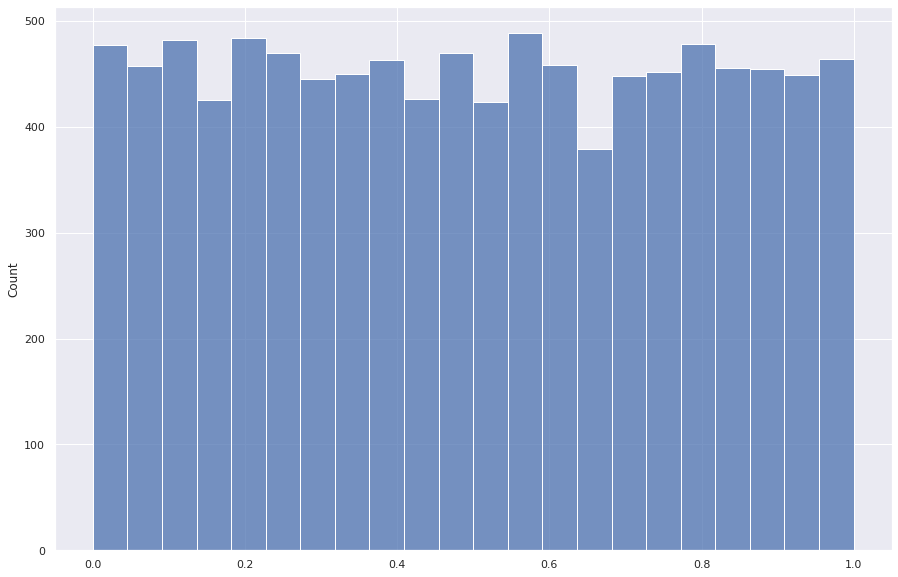

In [8]:

Pvalue_distibution= sns.histplot(p_values)

In [5]:
df_p_values = pd.DataFrame({'p_values':p_values})
procent_of_error = df_p_values[df_p_values.p_values <= 0.05].count()*100/df_p_values.count()

In [22]:
print('Можно заметить, что p-value распределилось равномерно и в большинстве случаев значение больше 0,05 - это означает, \nчто у нас нет оснований отвергать нулевую гипотезу о равенстве 2 групп. \nВероятность того что p_value <= 0.05 составляет {procent_of_error} %. \nАА тест прошел успешно, система сплитования работает корректно!'.format(procent_of_error=procent_of_error.to_list()[0]))

Можно заметить, что p-value распределилось равномерно и в большинстве случаев значение больше 0,05 - это означает, 
что у нас нет оснований отвергать нулевую гипотезу о равенстве 2 групп. 
Вероятность того что p_value <= 0.05 составляет 5.17 %. 
АА тест прошел успешно, система сплитования работает корректно!


In [ ]:
# Task 2

In [3]:
q = '''
      Select 
          exp_group,
          user_id,
          countIf(user_id, action = 'like') as likes,
          countIf(user_id, action = 'view') as views,
          likes/views as CTR
      from simulator_20220220.feed_actions
      where toDate(time) >= '2022-02-13' and toDate(time) <= '2022-02-19' 
          and exp_group in (1,2)
      group by exp_group, user_id
     '''

df_AB = pandahouse.read_clickhouse(q, connection = connection)

In [4]:
# ttest
stats.ttest_ind(df_AB[df_AB.exp_group == 1].CTR, 
                df_AB[df_AB.exp_group == 2].CTR,
                equal_var = False)

Ttest_indResult(statistic=0.7094392041270486, pvalue=0.4780623130874935)

In [5]:
''' Судя по Т-тесту группы существенно не различаются. Вероятно потому, что средние значения групп очень близки, 
    а также распределение группы 2 слишком далеко от нормальности (2 пика, длинные хвосты).'''
[df_AB[df_AB.exp_group == 1].CTR.mean(),df_AB[df_AB.exp_group == 2].CTR.mean()]

[0.21560459841296287, 0.21441927347479375]

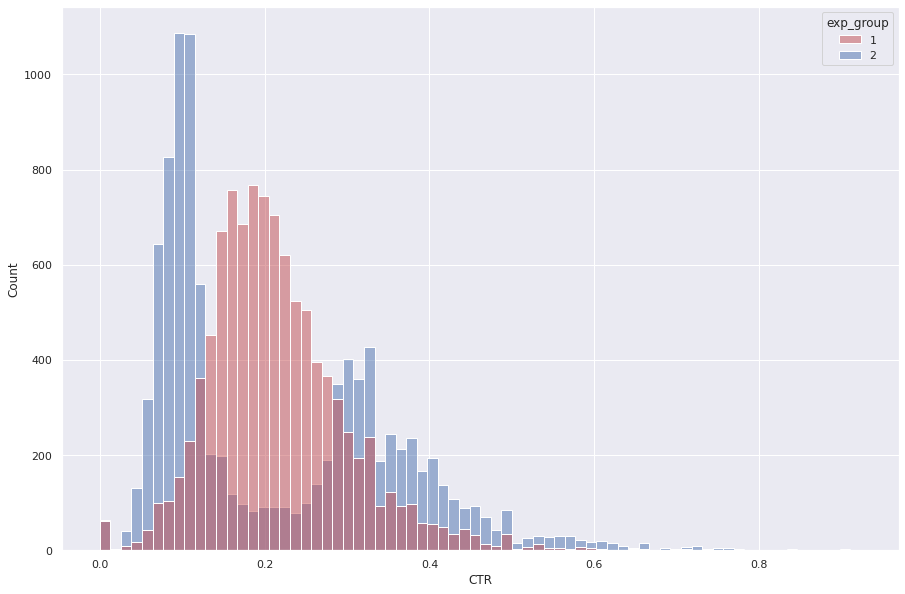

In [16]:
# visualisation
groups = sns.histplot(data = df_AB,
                        x='CTR',
                        hue='exp_group',
                        palette = ['r', 'b'],
                        kde=False)
# Однако на графике очевидно различие! 

In [7]:
# Manna Whitneyu test
stats.mannwhitneyu(df_AB[df_AB.exp_group == 1].CTR, 
                    df_AB[df_AB.exp_group == 2].CTR,
                    alternative="two-sided")
# Манна-Уитни показал четкое различие в группах.

MannwhitneyuResult(statistic=56601260.5, pvalue=6.0376484617779035e-56)

In [8]:
# Smoothed CTR
Global_CTR_control = df_AB[df_AB.exp_group == 1].likes.sum()/df_AB[df_AB.exp_group == 1].views.sum()
Global_CTR_target = df_AB[df_AB.exp_group == 2].likes.sum()/df_AB[df_AB.exp_group == 2].views.sum()

In [9]:
def Get_Smoothed_CTR(Global_CTR,likes,views,a):
    smoothed_CTR = (likes + a*Global_CTR)/(views + a)
    return smoothed_CTR

In [10]:
df_control = df_AB[df_AB.exp_group == 1].copy()
df_target = df_AB[df_AB.exp_group == 2].copy()

In [8]:
df_control

,exp_group,user_id,likes,views,CTR
0,1,109963,3,15,0.200000
1,1,26117,32,141,0.226950
2,1,138232,18,73,0.246575
3,1,26295,33,122,0.270492
4,1,18392,7,32,0.218750
...,...,...,...,...,...
20020,1,31540,8,45,0.177778
20021,1,23359,23,91,0.252747
20024,1,110956,3,16,0.187500
20026,1,132567,45,296,0.152027


In [11]:
df_control['smoothed_CTR'] = df_control.apply(lambda x: Get_Smoothed_CTR(Global_CTR_control,x.likes,x.views,5), axis = 1)
df_target['smoothed_CTR'] = df_target.apply(lambda x: Get_Smoothed_CTR(Global_CTR_target,x.likes,x.views,5), axis = 1)

In [12]:
df_control

,exp_group,user_id,likes,views,CTR,smoothed_CTR
0,1,109963,3,15,0.200000,0.202007
1,1,26117,32,141,0.226950,0.226302
2,1,138232,18,73,0.246575,0.244104
3,1,26295,33,122,0.270492,0.268033
4,1,18392,7,32,0.218750,0.217301
...,...,...,...,...,...,...
20020,1,31540,8,45,0.177778,0.180803
20021,1,23359,23,91,0.252747,0.250418
20024,1,110956,3,16,0.187500,0.192387
20026,1,132567,45,296,0.152027,0.152957


In [13]:
stats.ttest_ind(df_control['smoothed_CTR'], 
                df_target['smoothed_CTR'],
                equal_var = False)
# Вместе со сглаженным CTR Т-тест показал различия, значит большую погрешность вносили пользователи с недбльшим количеством промотров.

Ttest_indResult(statistic=2.2841320431616983, pvalue=0.0223769815558559)

In [14]:
stats.mannwhitneyu(df_control['smoothed_CTR'], 
                    df_target['smoothed_CTR'],
                    alternative="two-sided")
# Манна Уитни по прежнему точен.

MannwhitneyuResult(statistic=56925125.0, pvalue=1.6163964114270227e-61)

<AxesSubplot:xlabel='smoothed_CTR', ylabel='Count'>

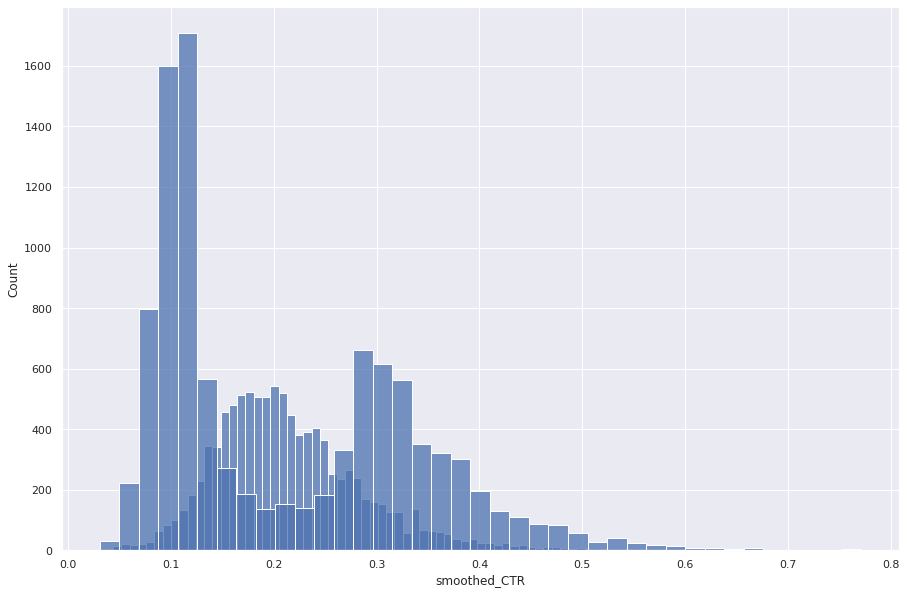

In [20]:
sns.histplot(df_control['smoothed_CTR'])
sns.histplot(df_target['smoothed_CTR'])
# Линии более сглаженные, но в целом также очевидно различие.

In [27]:
# Бустреп Пуассона
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):
    poisson_bootstraps1 = stats.poisson(1).rvs((n_bootstrap, len(likes1))).astype(np.int64)
    poisson_bootstraps2 = stats.poisson(1).rvs((n_bootstrap, len(likes2))).astype(np.int64)
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)
    return globalCTR1, globalCTR2

In [44]:
likes1 = df_AB[df_AB.exp_group == 1].likes.to_numpy()
views1 = df_AB[df_AB.exp_group == 1].views.to_numpy()
likes2 = df_AB[df_AB.exp_group == 2].likes.to_numpy()
views2 = df_AB[df_AB.exp_group == 2].views.to_numpy()
ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)


In [42]:
df_CTR1 = pd.DataFrame({'ctr':ctr1, 'exp_group': 1 })
df_CTR2 = pd.DataFrame({'ctr':ctr2, 'exp_group': 2 })
df_CTR = pd.concat([df_CTR1,df_CTR2])

<AxesSubplot:xlabel='ctr', ylabel='Count'>

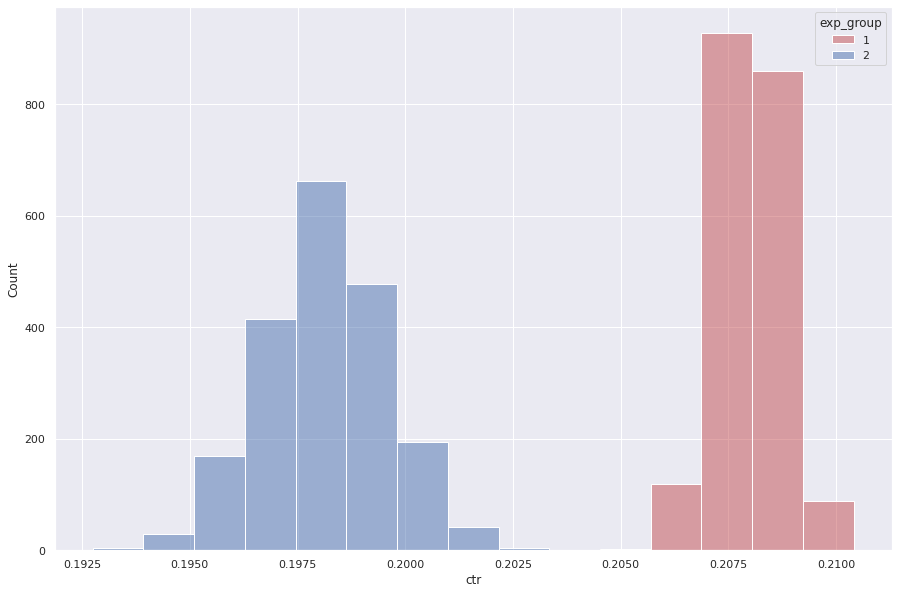

In [43]:
sns.histplot(data = df_CTR,
                        x='ctr',
                        hue='exp_group',
                        palette = ['r', 'b'],
                        kde=False)
# Бустреп показал четкое отличие графиков CTR групп 1 и 2. Распределение CTR контрольной группы имеет большие значения чем у таргет группы.

<AxesSubplot:ylabel='Count'>

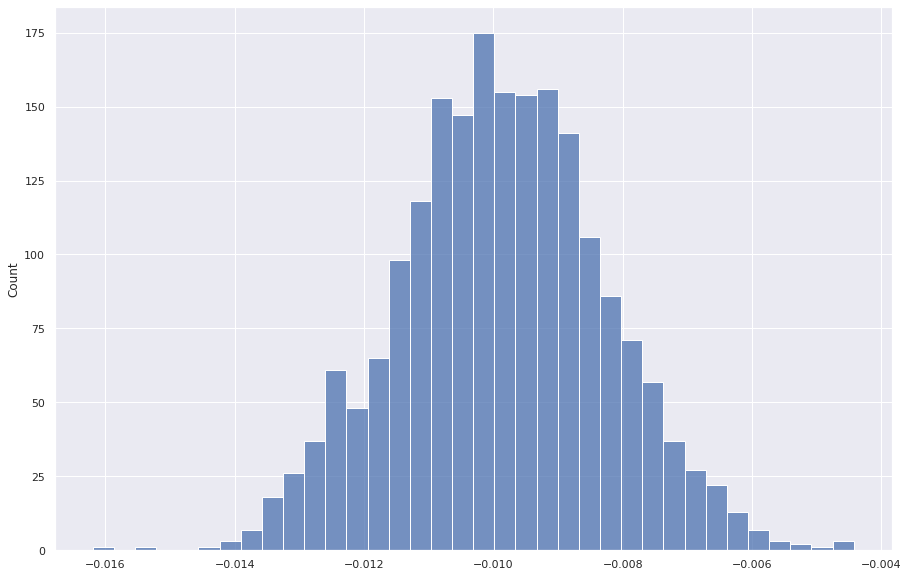

In [35]:
#Разница между распределениями глобальных CTR,  меньше нуля. 
sns.histplot(ctr2 - ctr1)

In [30]:
# Бакет преобразование
q = """
    SELECT exp_group, 
            bucket,
            sum(likes)/sum(views) as bucket_ctr
    FROM (SELECT exp_group,
            xxHash64(user_id)%50 as bucket,
            user_id,
            sum(action = 'like') as likes,
            sum(action = 'view') as views,
            likes/views as ctr
         FROM simulator_20220220.feed_actions
         WHERE toDate(time) >= '2022-02-13' and toDate(time) <= '2022-02-19' 
            and exp_group in (1,2)
         GROUP BY exp_group, bucket, user_id)
    GROUP BY exp_group, bucket
    """
df_bucket = pandahouse.read_clickhouse(q, connection=connection)

In [32]:
#тест Манна-Уитни вновь показал различия
stats.mannwhitneyu(df_bucket[df_bucket.exp_group == 1].bucket_ctr,
                    df_bucket[df_bucket.exp_group == 2].bucket_ctr,
                    alternative = 'two-sided')


MannwhitneyuResult(statistic=1995.0, pvalue=2.859963936492646e-07)

In [33]:
stats.ttest_ind(df_bucket[df_bucket.exp_group == 1].bucket_ctr,
                df_bucket[df_bucket.exp_group == 2].bucket_ctr,
                equal_var = False)
# Т-тест над баккетным преобразованием показал лучший результат точности среди всех т-тестов!

Ttest_indResult(statistic=5.668234732053979, pvalue=3.4455951649945907e-07)

In [ ]:
''' Итого, можно заключить что АВ тесты показали существенное различие между группами, но нововведение нет смысла вводить
    на всю генеральную совокупность, так как контрольная группа показала лучшие результаты искомой метрики.'''

In [ ]:
# Task 3

In [ ]:
'''Считаем общий CTR в контрольной группе  𝐶𝑇𝑅𝑐𝑜𝑛𝑡𝑟𝑜𝑙=𝑠𝑢𝑚(𝑙𝑖𝑘𝑒𝑠)/𝑠𝑢𝑚(𝑣𝑖𝑒𝑤𝑠) 
Посчитаем в обеих группах поюзерную метрику  𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠=𝑙𝑖𝑘𝑒𝑠−𝐶𝑇𝑅𝑐𝑜𝑛𝑡𝑟𝑜𝑙∗𝑣𝑖𝑒𝑤𝑠 
После чего сравним  t-тестом отличия в группах по метрике 𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠  
'''

In [65]:
CTRcontrol1 = df_control.likes.sum()/ df_control.views.sum()
CTRcontrol2 = df_target.likes.sum()/ df_target.views.sum()

In [66]:
CTRcontrol1

0.20802680490126244

In [67]:
def linearized_likes(likes, CTRcontrol, views):
    linearized_like = likes-CTRcontrol*views
    return linearized_like

In [68]:
df_control['linearized_likes'] = df_control.apply(lambda x: linearized_likes(x.likes, CTRcontrol1, x.views), axis = 1)
df_target['linearized_likes'] = df_target.apply(lambda x: linearized_likes(x.likes, CTRcontrol2, x.views), axis = 1)

In [69]:
df_total = pd.concat([df_control,df_target])

In [71]:
stats.ttest_ind(df_control['linearized_likes'], df_target['linearized_likes'], equal_var = False)

Ttest_indResult(statistic=-7.202349598490507e-15, pvalue=0.9999999999999942)

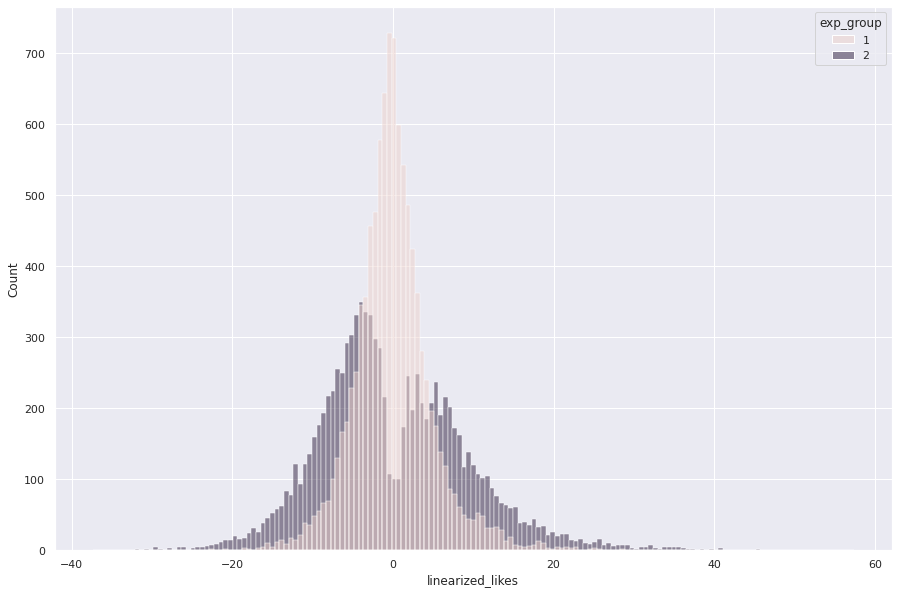

In [72]:
sns.histplot(data = df_total, x = 'linearized_likes', hue = 'exp_group')
sns.set()

In [ ]:
# Судя по графику различия между группами 1 и 2 очевидны, но по метрике линеаризованных лайков Т-тест не нашел существенных различий.

In [73]:
# Проверим группы 0 и 3
q = '''
      Select 
          exp_group,
          user_id,
          countIf(user_id, action = 'like') as likes,
          countIf(user_id, action = 'view') as views,
          likes/views as CTR
      from simulator_20220220.feed_actions
      where toDate(time) >= '2022-02-13' and toDate(time) <= '2022-02-19' 
          and exp_group in (0,3)
      group by exp_group, user_id
     '''

df_AB = pandahouse.read_clickhouse(q, connection = connection)

In [74]:
df_control = df_AB[df_AB.exp_group == 0].copy()
df_target = df_AB[df_AB.exp_group == 3].copy()

In [81]:
stats.ttest_ind(df_control['CTR'], df_target['CTR'], equal_var = False)
# Т-тест заметил значительное различие между распределениями CTR групп 0 и 3  

Ttest_indResult(statistic=-13.896870721904069, pvalue=1.055849414662529e-43)

<AxesSubplot:xlabel='CTR', ylabel='Count'>

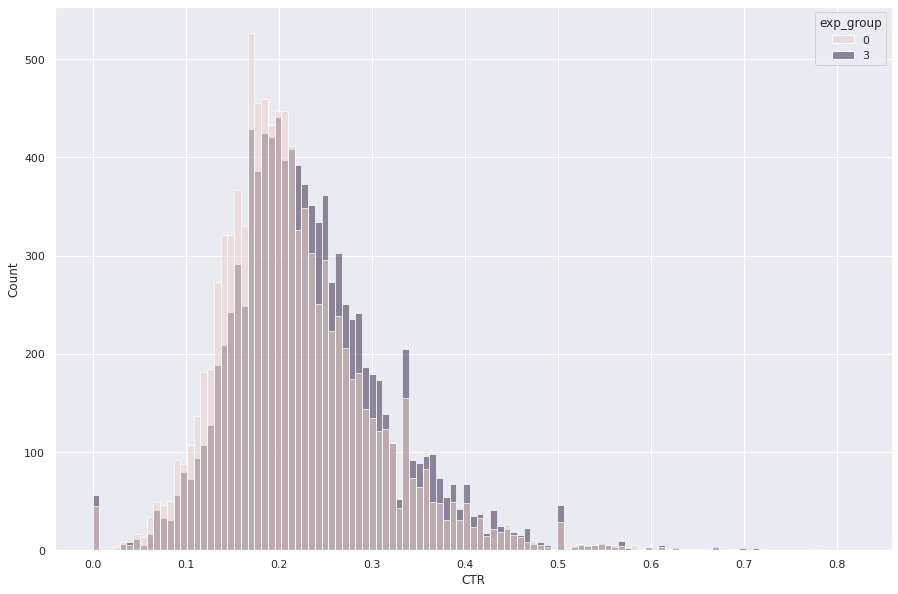

In [80]:
sns.histplot(data = df_AB, x = 'CTR', hue = 'exp_group')

In [75]:
CTRcontrol0 = df_control.likes.sum()/ df_control.views.sum()
CTRcontrol3 = df_target.likes.sum()/ df_target.views.sum()

In [76]:
df_control['linearized_likes'] = df_control.apply(lambda x: linearized_likes(x.likes, CTRcontrol0, x.views), axis = 1)
df_target['linearized_likes'] = df_target.apply(lambda x: linearized_likes(x.likes, CTRcontrol3, x.views), axis = 1)

In [77]:
df_total = pd.concat([df_control,df_target])

In [78]:
stats.ttest_ind(df_control['linearized_likes'], df_target['linearized_likes'], equal_var = False)

Ttest_indResult(statistic=-1.5428524700480617e-15, pvalue=0.9999999999999988)

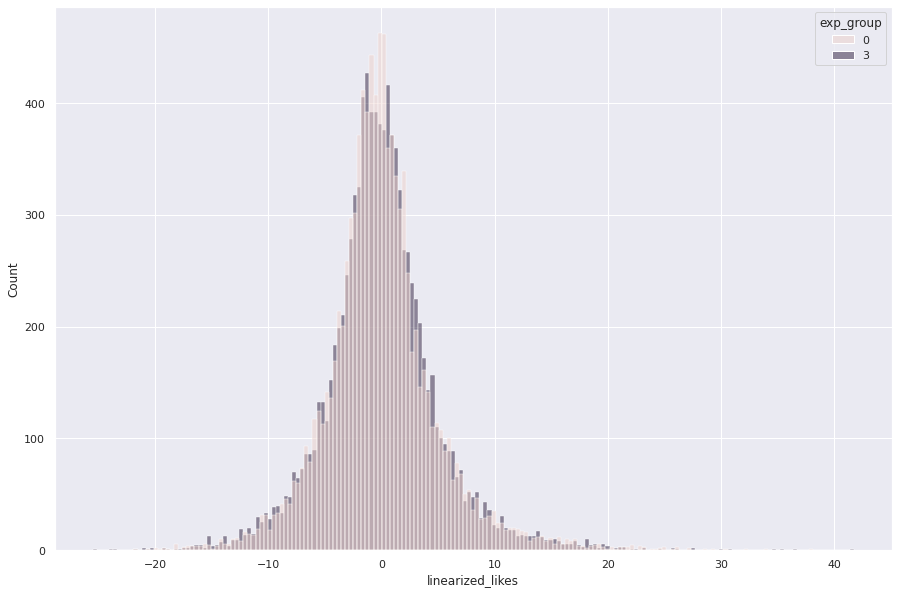

In [79]:
sns.histplot(data = df_total, x = 'linearized_likes', hue = 'exp_group')
sns.set()

In [ ]:
# Различия по графику между группами 0 и 3 неочевидны, по метрике линеаризованных лайков Т-тест не нашел существенных различий.